# Test embeddings for capabilities on product abbreviations

In [28]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.manifold import TSNE

import ast 

from mistralai.client import MistralClient

client = MistralClient(api_key="oppSIXvbwl8pQs6qFQ81afiNYks58C21")


In [20]:
df_complete = pd.read_csv('../data/name_embeds_complete_no_context.csv', index_col=0)

In [22]:
df_complete.head(3)

,name,price,category,embeddings
0,Alete Abendbrei Bio Keksbrei 190g,1.29,Babybedarf,"[-0.047637939453125, 0.006134033203125, 0.0454..."
1,Alete Abendmahlzeit zum Trinken Mehrkorn-Getre...,1.99,Babybedarf,"[-0.033355712890625, 0.0202789306640625, 0.022..."
2,Alete Bio Apfel-Pfirsich mit Keks nach 4. Mona...,1.29,Babybedarf,"[-0.05810546875, 0.0166778564453125, 0.0557556..."


In [15]:
df_abbr = pd.read_csv('../data/rewe_bons.csv', sep=';', decimal=',')

In [23]:
df_abbr.head(3)

,receipt,product_abbr,price
0,1,VOLLKORNTORTILLA,2.58
1,1,TOFU NATUR,4.38
2,1,HAUCHSCHN CURRY,3.18


In [87]:
def get_embeddings_by_chunks(data, chunk_size):
    chunks = [data[x : x + chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings_response = [
        client.embeddings(model="mistral-embed", input=c) for c in chunks
    ]
    return [d.embedding for e in embeddings_response for d in e.data]

#df_abbr["embeddings"] = get_embeddings_by_chunks(df_abbr["product_abbr"].tolist(), 50)
#df_abbr.to_csv('../data/abbr_embeds_no_context.csv')
df_abbr = pd.read_csv('../data/abbr_embeds_no_context.csv', index_col=0)
df_abbr




,receipt,product_abbr,price,embeddings
0,1,VOLLKORNTORTILLA,2.58,"[-0.04034423828125, -0.005352020263671875, 0.0..."
1,1,TOFU NATUR,4.38,"[-0.0147705078125, -0.0022411346435546875, 0.0..."
2,1,HAUCHSCHN CURRY,3.18,"[-0.0377197265625, -0.004734039306640625, 0.06..."
3,1,HONEYPOMELO PINK,2.99,"[-0.00493621826171875, -0.0181884765625, 0.060..."
4,1,DINKEL-CRUNCHY,2.59,"[0.01094818115234375, -0.00835418701171875, 0...."
...,...,...,...,...
138,15,WERNESGR. ALKFR,1.99,"[-0.0025997161865234375, 0.0118255615234375, 0..."
139,15,WERNESGR. ALKFR,11.40,"[-0.0025997161865234375, 0.0118255615234375, 0..."
140,15,"PFAND 0,08 EUR",0.96,"[-0.00926971435546875, -0.006359100341796875, ..."
141,15,MUELLSACK 60L,3.99,"[-0.0213165283203125, 0.000835418701171875, 0...."


For reference:
```py
def test_embeddings(sentences, reference):
    embeddings = [get_text_embedding(t) for t in sentences]

    reference_embedding = get_text_embedding(reference)

    print('Reference: ', reference)
    for t, e in zip(sentences, embeddings):
        distance = euclidean_distances([e], [reference_embedding])
        
        print(t, distance)



In [25]:
tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(df_abbr['embeddings'].to_list()))


<Axes: >

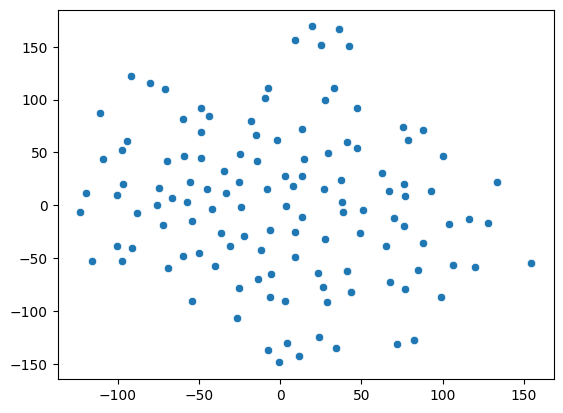

In [26]:
sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1])

In [32]:
# convert embeddings column to numpy array of dimension 1000 x 1024 - every product name embedding has 1024 features
embeddings = df_complete.embeddings.tolist()
retrieval_embeddings = np.array([ast.literal_eval(e) for e in embeddings])

In [49]:
embeddings = df_abbr.embeddings.tolist()
query_embeddings = np.array([ast.literal_eval(e) for e in embeddings])

In [50]:
def find_closest_embedding(query_embedding, retrieval_embedding):
    # Compute pairwise cosine similarity between query and table embeddings
    sim_matrix = cosine_similarity([query_embedding], retrieval_embeddings)
    
    # Find max similarity score & its index
    max_index = np.argmax(sim_matrix)
    max_similarity = sim_matrix[0][max_index]
    
    return max_index, max_similarity

In [51]:
query_embeddings[0]

array([-0.04034424, -0.00535202,  0.02728271, ..., -0.01986694,
        0.00428772, -0.01945496])

In [60]:
df_abbr

,receipt,product_abbr,price,embeddings
0,1,VOLLKORNTORTILLA,2.58,"[-0.04034423828125, -0.005352020263671875, 0.0..."
1,1,TOFU NATUR,4.38,"[-0.0147705078125, -0.0022411346435546875, 0.0..."
2,1,HAUCHSCHN CURRY,3.18,"[-0.0377197265625, -0.004734039306640625, 0.06..."
3,1,HONEYPOMELO PINK,2.99,"[-0.00493621826171875, -0.0181884765625, 0.060..."
4,1,DINKEL-CRUNCHY,2.59,"[0.01094818115234375, -0.00835418701171875, 0...."
...,...,...,...,...
138,15,WERNESGR. ALKFR,1.99,"[-0.0025997161865234375, 0.0118255615234375, 0..."
139,15,WERNESGR. ALKFR,11.40,"[-0.0025997161865234375, 0.0118255615234375, 0..."
140,15,"PFAND 0,08 EUR",0.96,"[-0.00926971435546875, -0.006359100341796875, ..."
141,15,MUELLSACK 60L,3.99,"[-0.0213165283203125, 0.000835418701171875, 0...."


In [77]:
print(f'Finding closest to {df_abbr.iloc[0].product_abbr}')

max_index, max_similarity = find_closest_embedding(query_embeddings[0], retrieval_embeddings)

print('Best match:', df_complete.iloc[max_index]['name'])
print('Similarity:', max_similarity)

Finding closest to VOLLKORNTORTILLA 
Best match: Palapa Vollkorntortilla 370g
Similarity: 0.8383450857985346


In [78]:
len(df_abbr)

143

In [79]:
prod_index = list()
embed_simil = list()

for i in range(len(df_abbr)):
    # Loop through abbreviations and find the closest match
    max_index, max_similarity = find_closest_embedding(query_embeddings[i], retrieval_embeddings)

    prod_index.append(max_index)
    embed_simil.append(max_similarity)




In [88]:
df_abbr['prod_id'] = prod_index
df_abbr['prod_similarity'] = embed_simil

In [89]:
df_abbr

,receipt,product_abbr,price,embeddings,prod_id,prod_similarity
0,1,VOLLKORNTORTILLA,2.58,"[-0.04034423828125, -0.005352020263671875, 0.0...",15363,0.838345
1,1,TOFU NATUR,4.38,"[-0.0147705078125, -0.0022411346435546875, 0.0...",5603,0.855739
2,1,HAUCHSCHN CURRY,3.18,"[-0.0377197265625, -0.004734039306640625, 0.06...",6099,0.809469
3,1,HONEYPOMELO PINK,2.99,"[-0.00493621826171875, -0.0181884765625, 0.060...",13853,0.886331
4,1,DINKEL-CRUNCHY,2.59,"[0.01094818115234375, -0.00835418701171875, 0....",1345,0.832309
...,...,...,...,...,...,...
138,15,WERNESGR. ALKFR,1.99,"[-0.0025997161865234375, 0.0118255615234375, 0...",14091,0.754391
139,15,WERNESGR. ALKFR,11.40,"[-0.0025997161865234375, 0.0118255615234375, 0...",14091,0.754391
140,15,"PFAND 0,08 EUR",0.96,"[-0.00926971435546875, -0.006359100341796875, ...",8181,0.784003
141,15,MUELLSACK 60L,3.99,"[-0.0213165283203125, 0.000835418701171875, 0....",13734,0.821446


In [81]:
df_complete.reset_index(names='prod_id')

,prod_id,name,price,category,embeddings
0,0,Alete Abendbrei Bio Keksbrei 190g,1.29,Babybedarf,"[-0.047637939453125, 0.006134033203125, 0.0454..."
1,1,Alete Abendmahlzeit zum Trinken Mehrkorn-Getre...,1.99,Babybedarf,"[-0.033355712890625, 0.0202789306640625, 0.022..."
2,2,Alete Bio Apfel-Pfirsich mit Keks nach 4. Mona...,1.29,Babybedarf,"[-0.05810546875, 0.0166778564453125, 0.0557556..."
3,3,Alete Bio Banane-Apfel mit Vollkorn-Getreide 190g,1.29,Babybedarf,"[-0.0217742919921875, 0.0098724365234375, 0.04..."
4,4,Alete Bio Erbseneintopf 250g,1.59,Babybedarf,"[-0.03509521484375, 0.01074981689453125, 0.061..."
...,...,...,...,...,...
19116,19116,ja! Tafelsalz 500g,0.25,"Öle, Soßen & Gewürze","[-0.025177001953125, 0.0115814208984375, 0.045..."
19117,19117,ja! Tomate-Basilikum Pasta-Sauce 400g,1.59,"Öle, Soßen & Gewürze","[-0.0157318115234375, 0.0177764892578125, 0.03..."
19118,19118,ja! Tomaten-Ketchup 500ml,1.79,"Öle, Soßen & Gewürze","[-0.015594482421875, 0.01385498046875, 0.04638..."
19119,19119,ja! Tomatenmark 3-fach konzentriert 200g,1.09,"Öle, Soßen & Gewürze","[-0.01306915283203125, 0.0239410400390625, 0.0..."


In [95]:
df_match = pd.merge(df_abbr, df_complete.reset_index(names='prod_id'), how='left', on='prod_id', suffixes=['_receipt', '_web'])
df_match

,receipt,product_abbr,price_receipt,embeddings_receipt,prod_id,prod_similarity,name,price_web,category,embeddings_web
0,1,VOLLKORNTORTILLA,2.58,"[-0.04034423828125, -0.005352020263671875, 0.0...",15363,0.838345,Palapa Vollkorntortilla 370g,2.29,Süßes & Salziges,"[-0.026336669921875, -0.01849365234375, 0.0394..."
1,1,TOFU NATUR,4.38,"[-0.0147705078125, -0.0022411346435546875, 0.0...",5603,0.855739,Berief Bio Tofu Natur 2x200g,2.49,Fleisch & Fisch,"[-0.039794921875, 0.00988006591796875, 0.04229..."
2,1,HAUCHSCHN CURRY,3.18,"[-0.0377197265625, -0.004734039306640625, 0.06...",6099,0.809469,Rügenwalder Mühle Hauchschnitt Curry Typ Hähnc...,1.59,Fleisch & Fisch,"[-0.017303466796875, -0.0184478759765625, 0.07..."
3,1,HONEYPOMELO PINK,2.99,"[-0.00493621826171875, -0.0181884765625, 0.060...",13853,0.886331,Honey Pomelo Pink 1 Stück,2.99,Obst & Gemüse,"[-0.0116119384765625, -0.004703521728515625, 0..."
4,1,DINKEL-CRUNCHY,2.59,"[0.01094818115234375, -0.00835418701171875, 0....",1345,0.832309,REWE Bio Naturland Dinkel Crunchy 500g,2.59,"Brot, Cerealien & Aufstriche","[0.007778167724609375, -0.0036411285400390625,..."
...,...,...,...,...,...,...,...,...,...,...
138,15,WERNESGR. ALKFR,1.99,"[-0.0025997161865234375, 0.0118255615234375, 0...",14091,0.754391,Arko Erdnusstaler 200g,2.99,Süßes & Salziges,"[-0.04254150390625, 0.00545501708984375, 0.051..."
139,15,WERNESGR. ALKFR,11.40,"[-0.0025997161865234375, 0.0118255615234375, 0...",14091,0.754391,Arko Erdnusstaler 200g,2.99,Süßes & Salziges,"[-0.04254150390625, 0.00545501708984375, 0.051..."
140,15,"PFAND 0,08 EUR",0.96,"[-0.00926971435546875, -0.006359100341796875, ...",8181,0.784003,"Pfanner Eistee Pfirsich 0,33l",1.29,Getränke & Genussmittel,"[-0.0310516357421875, -0.0007419586181640625, ..."
141,15,MUELLSACK 60L,3.99,"[-0.0213165283203125, 0.000835418701171875, 0....",13734,0.821446,ja! Müllsäcke 60l mit Zugbeutel 25 Stück,2.49,Küche & Haushalt,"[-0.042938232421875, 0.0267486572265625, 0.068..."


In [96]:
df_match.to_csv('../data/matched_abbr_to_names.csv')